In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import datetime, timedelta

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GroupKFold, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, make_scorer

from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

import xgboost as xgb

%matplotlib inline

In [2]:
def RMSLE(y_true, y_pred, log=True):
#     y_true, y_pred = np.exp(y_true), np.exp(y_pred)
    assert len(y_true) == len(y_pred)
    
#     return np.sqrt(np.sum(np.square(np.log(y_true + 1) - np.log(y_pred + 1))) / y_true.shape[0])
    if log:
        return np.sqrt(np.sum(np.square(y_true - y_pred) / y_true.shape[0]))
    else:
        return np.sqrt(np.sum(np.square(np.log(y_true + 1) - np.log(y_pred + 1))) / y_true.shape[0])

In [3]:
RMSLEScorer = make_scorer(RMSLE, greater_is_better=True)

In [4]:
train = pd.read_csv("Data/train.csv") 
test = pd.read_csv("Data/test.csv")

In [5]:
train["TRDATETIME"] = pd.to_datetime(train.TRDATETIME, format='%d%b%y:%H:%M:%S')
test["TRDATETIME"] = pd.to_datetime(test.TRDATETIME, format='%d%b%y:%H:%M:%S')

In [6]:
train["log_target_sum"] = np.log(train.target_sum + 1)

In [7]:
train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,log_target_sum
0,01/10/2017,0,5200,NaN,810,2017-10-21 00:00:00,5023.0,POS,0,0.0,0.0
1,01/10/2017,0,6011,NaN,810,2017-10-12 12:24:07,20000.0,DEPOSIT,0,0.0,0.0
2,01/12/2017,0,5921,NaN,810,2017-12-05 00:00:00,767.0,POS,0,0.0,0.0
3,01/10/2017,0,5411,NaN,810,2017-10-21 00:00:00,2031.0,POS,0,0.0,0.0
4,01/10/2017,0,6012,NaN,810,2017-10-24 13:14:24,36562.0,C2C_OUT,0,0.0,0.0


In [8]:
train.corr()

,cl_id,MCC,currency,amount,target_flag,target_sum,log_target_sum
cl_id,1.000000,-0.004789,0.000630,0.002446,-0.410436,-0.075423,-0.464289
MCC,-0.004789,1.000000,0.000547,0.019986,0.013118,-0.017400,0.015659
currency,0.000630,0.000547,1.000000,-0.040777,-0.013644,-0.002662,-0.010651
amount,0.002446,0.019986,-0.040777,1.000000,-0.003336,-0.001133,-0.002134
target_flag,-0.410436,0.013118,-0.013644,-0.003336,1.000000,0.080548,0.949304
target_sum,-0.075423,-0.017400,-0.002662,-0.001133,0.080548,1.000000,0.143404
log_target_sum,-0.464289,0.015659,-0.010651,-0.002134,0.949304,0.143404,1.000000


In [9]:
k = train["cl_id"].unique()
v = train.groupby("cl_id")["target_flag"].value_counts().values
d = {k[i] : v[i] for i in range(k.shape[0])}
train["use_count"] = train["cl_id"].apply(lambda x: d[x])

In [10]:
k = test["cl_id"].unique()
v = test.groupby("cl_id")["cl_id"].value_counts().values
d = {k[i] : v[i] for i in range(k.shape[0])}
test["use_count"] = test["cl_id"].apply(lambda x: d[x])

In [13]:
delta_use = train[train.trx_category == "POS"].sort_values("TRDATETIME").groupby('cl_id')["TRDATETIME"].apply(lambda x: x[1:].append([x[:1]+timedelta(weeks=4*3)]).reset_index(drop=True) - x.reset_index(drop=True))
delta_use = delta_use.apply(lambda x: x.days if x.days >=0 else 0)

In [11]:
new_train = pd.DataFrame()
new_test = pd.DataFrame()

In [12]:
m = dict(train.groupby("channel_type")["target_flag"].agg("mean"))

In [71]:
m = dict(train.groupby("MCC")["target_flag"].agg("mean"))
train["MCC_encoded"] = train.MCC.map(m)

In [14]:
m = {name: i+1 for i, name in enumerate(train.channel_type.unique())}
# m = dict(train.groupby("channel_type")["target_flag"].agg("mean"))
train["encoded_channel_type"] = train.channel_type.map(m)

In [16]:
category_sign = {
   'POS' : -1,
   'DEPOSIT' : 1,
   'C2C_OUT' : -1,
   'WD_ATM_ROS' : -1,
   'BACK_TRX' : 1,
   'WD_ATM_PARTNER' : -1,
   'WD_ATM_OTHER' : -1,
   'C2C_IN' : 1,
   'CAT' : -1,
   'CASH_ADV' : -1,
}

In [17]:
train["signed_amount"] = train.trx_category.map(category_sign) * train.amount

In [18]:
channel_type_sign = {
    "type1" : 1,
    "type2" : 1,
    "type3" : 1,
    "type4" : -1,
    "type5" : -1
}

In [19]:
new_train = pd.DataFrame()

In [20]:
channel_type = train.groupby("cl_id").channel_type.first().reset_index(drop=True)

In [17]:
plt.figure(figsize=(15, 10))
sns.heatmap(new_train[channel_type == "type1"].corr(), annot=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 1080x720 with 0 Axes>

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(new_train[channel_type == "type2"].corr(), annot=True)

In [17]:
new_train["channel_type"] = train.groupby("cl_id").channel_type.first().reset_index(drop=True).fillna("type1")

In [308]:
# # Generate Train set
# # new_train = tmp
new_train = train[["cl_id", "amount", "trx_category"]].groupby(["cl_id", "trx_category"]).agg("sum").unstack().fillna(0)
new_test = test[["cl_id", "amount", "trx_category"]].groupby(["cl_id", "trx_category"]).agg("sum").unstack().fillna(0).apply(lambda x: np.log(x+1))

new_train.columns = new_train.columns.droplevel()
new_test.columns = new_test.columns.droplevel()

In [309]:
# new_train = new_train.apply(lambda x: np.log(x+1), axis=0)

In [310]:
# # Generate Train set
# new_train = train.groupby("cl_id")["trx_category"].value_counts().unstack().fillna(0)
# new_test = test.groupby("cl_id")["trx_category"].value_counts().unstack().fillna(0)

In [311]:
# new_train["amount"] = np.log(train.groupby("cl_id").amount.agg("sum") + 1)

In [312]:
# new_train = train.groupby("cl_id")["trx_category"].value_counts().unstack().fillna(0)

In [313]:
# new_train = pd.concat((new_train, mcc_group), axis=1)

In [314]:
# new_train["pred"] = pred

In [315]:
# new_train = pd.concat((new_train, X_new), axis=1)

In [316]:
use_time = train[train.trx_category == "POS"][["cl_id", "TRDATETIME"]].groupby("cl_id").agg(["min", "max"]).apply(lambda x: x[1] - x[0], axis=1)
tmp = use_time.apply(lambda x: x.days)
new_train["useDays"] = tmp

use_time = test[test.trx_category == "POS"][["cl_id", "TRDATETIME"]].groupby("cl_id").agg(["min", "max"]).apply(lambda x: x[1] - x[0], axis=1)
tmp = use_time.apply(lambda x: x.days)
new_test["useDays"] = tmp

In [317]:
# amount
# new_train = pd.concat((new_train, train.groupby("cl_id").amount.agg(["sum", "mean", "max", "min"])), axis=1)
# new_test = pd.concat((new_test, test.groupby("cl_id").amount.agg(["sum", "mean", "max", "min"])), axis=1)

In [318]:
# tmp = pd.get_dummies(train.groupby("cl_id")["channel_type"].first())
# new_train = pd.concat((new_train, tmp.apply(lambda x: x * new_train["sum"], axis=0)), axis=1)

# tmp = pd.get_dummies(test.groupby("cl_id")["channel_type"].first())
# new_test = pd.concat((new_test, tmp.apply(lambda x: x * new_test["sum"], axis=0)), axis=1)

In [319]:
# tmp = train.groupby("cl_id").TRDATETIME.agg(["min", "max"])

# m = tmp.apply(lambda x: x.apply(lambda x: x.month)).rename(columns={"min" : "start_month", "max": "end_month"})
# new_train = pd.concat((new_train, m), axis=1)

# m = tmp.apply(lambda x: x.apply(lambda x: x.day)).rename(columns={"min" : "start_day", "max": "end_day"})
# new_train = pd.concat((new_train, m), axis=1)

In [320]:
# tmp = test.groupby("cl_id").TRDATETIME.agg(["min", "max"])

# m = tmp.apply(lambda x: x.apply(lambda x: x.month)).rename(columns={"min" : "start_month", "max": "end_month"})
# new_test = pd.concat((new_test, m), axis=1)

# m = tmp.apply(lambda x: x.apply(lambda x: x.day)).rename(columns={"min" : "start_day", "max": "end_day"})
# new_test = pd.concat((new_test, m), axis=1)

In [321]:
# tmp = train.groupby("cl_id")["MCC"].value_counts().unstack().fillna(0)
# m = tmp[5814] + tmp[6011] + tmp[5999] + tmp[5912] + tmp[5691] + tmp[5812]
# new_train = pd.concat((new_train, m), axis=1)

# tmp = test.groupby("cl_id")["MCC"].value_counts().unstack().fillna(0)
# m = tmp[5814] + tmp[6011] + tmp[5999] + tmp[5912] + tmp[5691] + tmp[5812]
# new_test = pd.concat((new_test, m), axis=1)

In [322]:
new_train["target_flag"] = train[["cl_id",'target_flag']].groupby('cl_id')["target_flag"].first()
new_train["log_target_sum"] = train[["cl_id",'log_target_sum']].groupby('cl_id')["log_target_sum"].first()
new_train["target_sum"] = train[["cl_id",'target_sum']].groupby('cl_id')["target_sum"].first()

In [323]:
# m = {name: i+1 for i, name in enumerate(train.channel_type.unique())}
# new_train["channel_type"] = train.groupby("cl_id").channel_type.first().map(m)

In [324]:
# new_train["pred"] = pred

In [325]:
# tmp = train.groupby("cl_id")["channel_type"].value_counts().unstack().fillna(0)
# new_train = pd.concat((new_train, tmp), axis=1)

# new_train["channel_type"] = train.groupby("cl_id")["channel_type"].first()
# new_test["channel_type"] = test.groupby("cl_id")["channel_type"].first()

# tmp = test.groupby("cl_id")["channel_type"].value_counts().unstack().fillna(0)
# new_test = pd.concat((new_test, tmp), axis=1)

In [326]:
new_train["use_count"] = train["cl_id"].value_counts()
new_train.use_count = np.log(new_train.use_count + 1)

new_test["use_count"] = test["cl_id"].value_counts()
new_test.use_count = np.log(new_test.use_count + 1)

In [327]:

# new_train["useDay"] = np.log(use_time.apply(lambda x: x.days) + 1)

# use_time = test[test.trx_category == "POS"][["cl_id", "TRDATETIME"]].groupby("cl_id").agg(["min", "max"]).apply(lambda x: x[1] - x[0], axis=1)
# new_test["useDay"] = np.log(use_time.apply(lambda x: x.days) + 1)

In [328]:
# new_train["delta"] = delta_use.groupby("cl_id").agg("mean")

In [329]:
# new_train = pd.concat((new_train, tmp), axis=1)

In [330]:
new_train = new_train.reset_index()
new_test = new_test.reset_index()

In [331]:
# new_train = pd.concat((new_train, X_new), axis=1)

In [332]:
test_target = new_test[["cl_id"]]

In [333]:
# tmp = pd.get_dummies(train.groupby("cl_id").channel_type.first()).reset_index(drop=True).apply(lambda x: x * new_train.cl_id, axis=0)
# new_train = pd.concat((new_train.drop("cl_id", axis=1), tmp), axis=1)

# test_target = new_test[["cl_id"]]

# tmp = pd.get_dummies(test.groupby("cl_id").channel_type.first()).reset_index(drop=True).apply(lambda x: x * new_test.cl_id, axis=0)
# new_test = pd.concat((new_test.drop("cl_id", axis=1), tmp), axis=1)

In [44]:
# new_train["MCC"] = mcc_group[6011]

In [45]:
# new_train["cl_id"] = train.groupby("cl_id")["channel_type"].first().map(channel_type_sign).fillna(1).reset_index(drop=True) * new_train.cl_id

In [184]:
def makeFeatures(dataset, train=False):
#     new_train = dataset[["cl_id", "amount", "trx_category"]].groupby(["cl_id", "trx_category"]).agg("sum").unstack().fillna(0)
#     new_train.columns = new_train.columns.droplevel()
    new_train = dataset.groupby("cl_id")[["cl_id"]].first()
    
#     new_train["MCC"] = dataset.groupby("cl_id")[["MCC_encoded"]].agg("mean")   
#     new_train["amount"] = np.log(dataset[dataset.trx_category == "POS"].groupby("cl_id").amount.agg("sum") + 1)

#     tmp = dataset.groupby(["cl_id"])["trx_category"].value_counts().unstack().fillna(0)
#     new_train = pd.concat((new_train, tmp), axis=1)
    
#     tmp = dataset[dataset.trx_category == "POS"].groupby(["cl_id", "channel_type"])["signed_amount"].agg("sum").unstack().fillna(0)
#     new_train = pd.concat((new_train, np.log(np.abs(tmp) + 1)), axis=1)
    
    tmp = dataset[dataset.trx_category == "POS"][["cl_id", "TRDATETIME"]].groupby("cl_id").agg(["min", "max"])
    tmp.columns = tmp.columns.droplevel()
    tmp["min"] = tmp["min"] + timedelta(weeks=4)
    tmp["max"] = tmp["max"] - timedelta(weeks=4)

        
    dmin = dict(tmp["min"])
    dmax = dict(tmp["max"])
    
    tmpmin = dataset[dataset.trx_category == "POS"].groupby("cl_id").apply(lambda x: x[x.TRDATETIME <= dmin[x.iloc[0].cl_id]]["amount"].sum() )
    tmpmax = dataset[dataset.trx_category == "POS"].groupby("cl_id").apply(lambda x: x[x.TRDATETIME >= dmax[x.iloc[0].cl_id]]["amount"].sum() )
    
    new_train["firstMonthAmount"] = np.log(tmpmin + 1)
    new_train["lastMonthAmount"] = np.log(tmpmax + 1)
    
    use_time = dataset[dataset.trx_category == "POS"][["cl_id", "TRDATETIME"]].groupby("cl_id").agg(["min", "max"]).apply(lambda x: x[1] - x[0], axis=1)
    tmp = use_time.apply(lambda x: x.days)
    new_train["useDays"] = tmp
    
    if (train):
        new_train["target_flag"] = dataset[["cl_id",'target_flag']].groupby('cl_id')["target_flag"].first()
        new_train["log_target_sum"] = dataset[["cl_id",'log_target_sum']].groupby('cl_id')["log_target_sum"].first()
#         new_train["target_sum"] = dataset[["cl_id",'target_sum']].groupby('cl_id')["target_sum"].first()
    
    return new_train.reset_index(drop=True)

In [185]:
new_train = makeFeatures(train, train=True)
# new_test = makeFeatures(test)

In [81]:
# new_train = pd.concat((new_train, amount_dif), axis=1)

In [192]:
new_test = makeFeatures(test)
test_target = new_test[["cl_id"]]

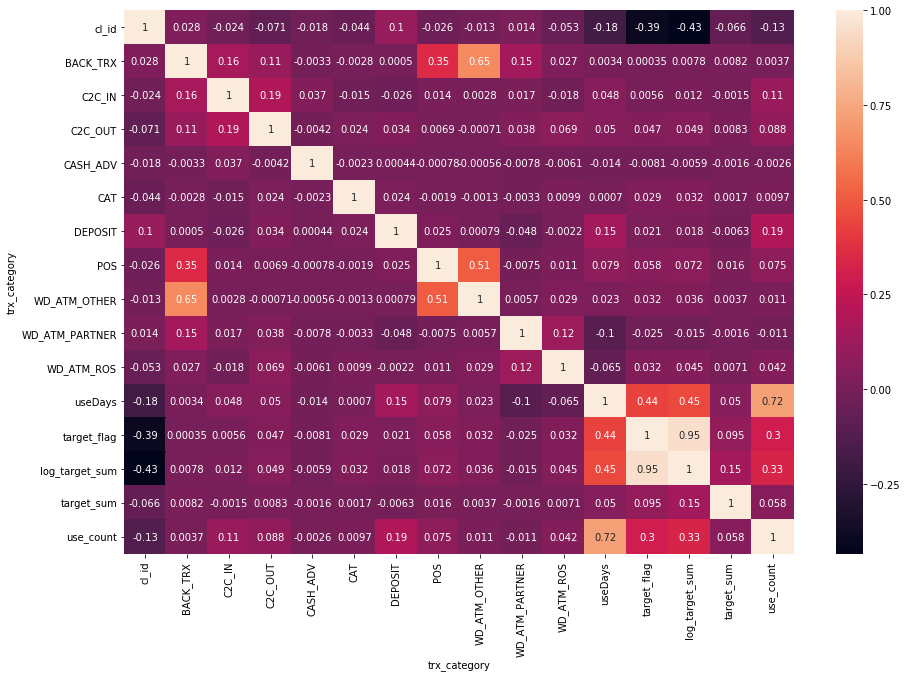

In [257]:
plt.figure(figsize=(15, 10))
sns.heatmap(new_train.corr(), annot=True)

In [280]:
folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=7)
xgbClassifier = xgb.XGBClassifier(max_depth=2, n_estimators=200, learning_rate=0.05)

In [281]:
X = new_train.drop(["target_flag", "log_target_sum", "target_sum"], axis=1).fillna(0)

In [282]:
xgbClassifier = xgb.XGBClassifier(n_estimators=100, max_depth=2, learning_rate=0.1)

In [283]:
cross_val_score(xgbClassifier, X, new_train.target_flag, scoring="roc_auc", cv=folds).mean()

0.8567956665635886

In [334]:
from sklearn.ensemble import RandomForestClassifier

In [355]:
rf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=17)

In [356]:
cv = cross_val_score(rf, X, new_train.target_flag, scoring="roc_auc", cv=folds)
print(cv.mean())
print(cv.std())

0.8570370222168677
0.006558975361317623


In [284]:
n_ests = [50, 100, 150, 200]
depths = [3, 4, 5]
lrs = [0.01, 0.1]

best_cv = 0

for n_est in n_ests:
    for depth in depths:
        for lr in lrs:
            xgbClassifier = xgb.XGBClassifier(max_depth=depth, n_estimators=n_est, learning_rate=lr)
            cv = cross_val_score(xgbClassifier, X, new_train.target_flag, 
                                 scoring="roc_auc", cv=folds).mean()

            if (cv > best_cv):
                best_cv = cv
                print("n_ests = {}, depth = {}, lr = {};\t cv = {}".format(n_est, depth, lr, cv))

n_ests = 50, depth = 3, lr = 0.01;	 cv = 0.8435497510872001
n_ests = 50, depth = 3, lr = 0.1;	 cv = 0.855347086342749
n_ests = 50, depth = 4, lr = 0.1;	 cv = 0.8566840539798846


In [357]:
rf.fit(X, new_train.target_flag)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [358]:
test_target["target_flag"] = rf.predict_proba(new_test)[:, 1]
d = dict(test_target.set_index("cl_id")["target_flag"])

test["target_flag"] = test.cl_id.apply(lambda x: d[x])

test[["cl_id", "target_flag"]].to_csv("task1.csv", index=False)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [61]:
pd.DataFrame(data=xgbClassifier.feature_importances_.reshape(1, -1), columns=X.columns)

,cl_id,firstMonthAmount,lastMonthAmount,useDays
0,0.391753,0.158076,0.206186,0.243986


In [159]:
pred = np.zeros(new_train.shape[0])
for X_train, X_test in folds.split(X, new_train.target_flag):
    xgbClassifier.fit(X.loc[X_train], new_train.loc[X_train].target_flag)
    pred[X_test] = xgbClassifier.predict_proba(X.loc[X_test])[:, 1]
    print(roc_auc_score(new_train.loc[X_test].target_flag, pred[X_test]))

0.8094463172262608
0.8259175523649699
0.806458087306027
0.8274188361369165


In [160]:
missClass = np.round(pred) != new_train.target_flag

In [161]:
new_train["missClass"] = 0
new_train.loc[missClass, "missClass"] = 1

In [162]:
new_train.to_pickle("new_train")

In [262]:
new_train.missClass.value_counts()

0    3786
1    1214
Name: missClass, dtype: int64

In [263]:
train.groupby("cl_id").channel_type.first().reset_index(drop=True).value_counts()

type1    3321
type2    1492
type4      58
type5      56
type3      48
Name: channel_type, dtype: int64

In [264]:
train.groupby("cl_id").channel_type.first().reset_index(drop=True)[new_train.missClass == 1].value_counts()

type1    968
type2    198
type5     16
type4     15
type3     11
Name: channel_type, dtype: int64

In [495]:
new_train["channel_type"] = train.groupby("cl_id").encoded_channel_type.first()

In [173]:
new_train = pd.read_pickle("new_train")

In [177]:
train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,log_target_sum,use_count,encoded_channel_type,MCC_encoded,signed_amount
0,01/10/2017,0,5200,NaN,810,2017-10-21 00:00:00,5023.0,POS,0,0.0,0.0,5,1,0.493353,-5023.0
1,01/10/2017,0,6011,NaN,810,2017-10-12 12:24:07,20000.0,DEPOSIT,0,0.0,0.0,5,1,0.653231,20000.0
2,01/12/2017,0,5921,NaN,810,2017-12-05 00:00:00,767.0,POS,0,0.0,0.0,5,1,0.672651,-767.0
3,01/10/2017,0,5411,NaN,810,2017-10-21 00:00:00,2031.0,POS,0,0.0,0.0,5,1,0.619393,-2031.0
4,01/10/2017,0,6012,NaN,810,2017-10-24 13:14:24,36562.0,C2C_OUT,0,0.0,0.0,5,1,0.567721,-36562.0


In [178]:
def makeFeatures2(dataset, train=False):
#     new_train = dataset[["cl_id", "amount", "trx_category"]].groupby(["cl_id", "trx_category"]).agg("sum").unstack().fillna(0)
#     new_train.columns = new_train.columns.droplevel()
    new_train = dataset.groupby("cl_id")[["cl_id"]].first()
    
       
#     new_train["amount"] = np.log(dataset[dataset.trx_category == "POS"].groupby("cl_id").amount.agg("sum") + 1)

    tmp = dataset[dataset.trx_category == "POS"].groupby(["cl_id", "channel_type"])["signed_amount"].agg("sum").unstack().fillna(0)
    new_train = pd.concat((new_train, np.log(np.abs(tmp) + 1)), axis=1)
    
    use_time = dataset[dataset.trx_category == "POS"][["cl_id", "TRDATETIME"]].groupby("cl_id").agg(["min", "max"]).apply(lambda x: x[1] - x[0], axis=1)
    tmp = use_time.apply(lambda x: x.days)
    new_train["useDays"] = tmp
    
    new_train["MCC"] = dataset.groupby("cl_id").MCC_encoded.agg("mean")
    
    new_train["use_count"] = dataset.groupby("cl_id").use_count.first()
    
    if (train):
        new_train["target_flag"] = dataset[["cl_id",'target_flag']].groupby('cl_id')["target_flag"].first()
        new_train["log_target_sum"] = dataset[["cl_id",'log_target_sum']].groupby('cl_id')["log_target_sum"].first()
        new_train["missClass"] = 0
#         new_train["target_sum"] = dataset[["cl_id",'target_sum']].groupby('cl_id')["target_sum"].first()
    
    return new_train.reset_index(drop=True)

In [179]:
new_train = makeFeatures2(train, train=True)
new_train.loc[missClass, "missClass"] = 1

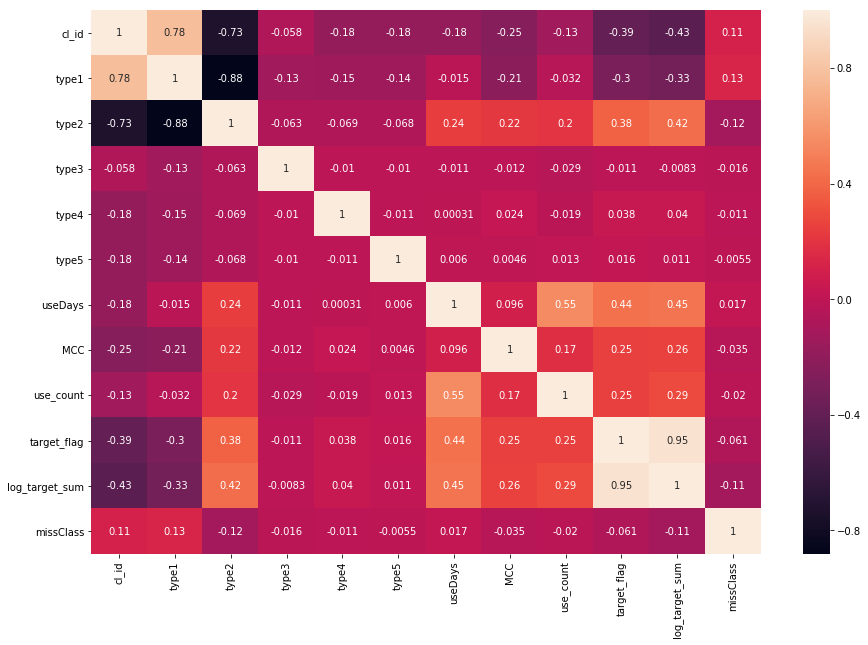

In [180]:
plt.figure(figsize=(15, 10))
sns.heatmap(new_train.corr(), annot=True)

In [181]:
X_new = new_train.drop(["target_flag", "log_target_sum", "missClass"], axis=1)

In [183]:
xgbClassifier = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1)
cross_val_score(xgbClassifier, X_new, new_train.missClass, scoring="roc_auc", cv=folds).mean()

0.7267621700788599

In [374]:
train["year"] = train.TRDATETIME.apply(lambda x: x.year)
train["month"] = train.TRDATETIME.apply(lambda x: x.month)
train["year_month"] = train.TRDATETIME.apply(lambda x: x.year * 100 + x.month)

In [376]:
train["day"] = train.TRDATETIME.apply(lambda x: x.day)
train["month_day"] = train.TRDATETIME.apply(lambda x: x.month * 100 + x.day)

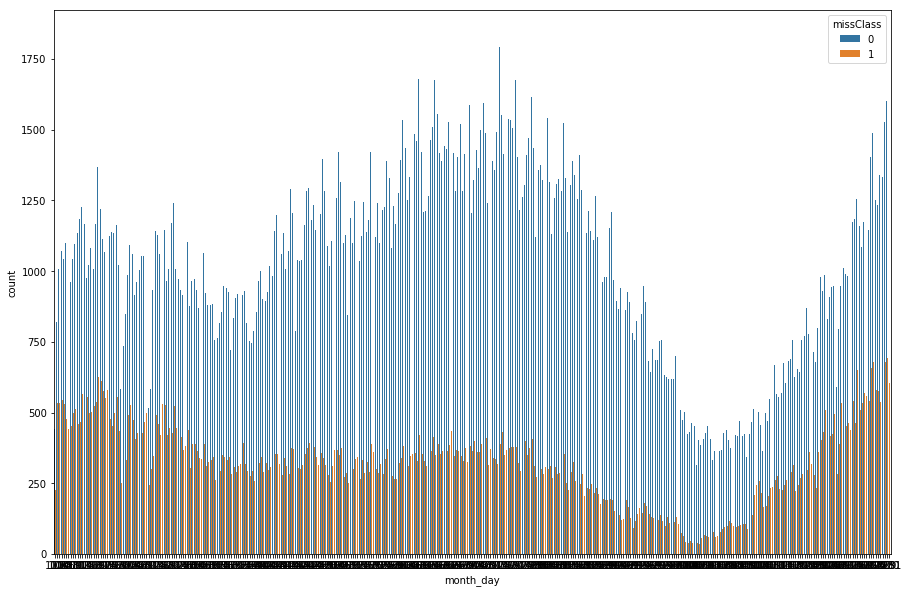

In [378]:
plt.figure(figsize=(15, 10))
sns.countplot(x="month_day", hue="missClass", data=train)

In [289]:
def cross_val_predict(est, train, target, kfold):
    pred = np.zeros(train.shape[0])
    for X_train, X_test in kfold.split(train, target):
        est.fit(train.loc[X_train], target[X_train])
        pred[X_test] = est.predict_proba(train.loc[X_test])[:, 1]
    return pred

In [573]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=70, max_depth=8, max_features=3, random_state=5)
rf.fit(X.drop("cl_id", axis=1), new_train.target_flag)
rf.feature_importances_
pred1 = cross_val_predict(rf, X.drop("cl_id", axis=1), new_train.target_flag, folds).reshape(-1, 1)

In [570]:
cross_val_score(rf, X.drop("cl_id", axis=1), new_train.target_flag, scoring="roc_auc", cv=folds).mean()

0.838821737992716

In [567]:
xgbClassifier.fit(X, new_train.target_flag)
pred2 = cross_val_predict(rf, X, new_train.target_flag, folds).reshape(-1, 1)
xgbClassifier.feature_importances_

array([0.24914676, 0.01365188, 0.01365188, 0.00682594, 0.        ,
       0.01023891, 0.13651878, 0.15017065, 0.05119454, 0.05802048,
       0.06484642, 0.03071672, 0.21501707], dtype=float32)

In [574]:
rf = RandomForestClassifier(n_estimators=70, max_depth=8, random_state=5)
cross_val_score(xgbClassifier, np.hstack((pred1, pred2)), new_train.target_flag, scoring="roc_auc", cv=folds).mean()

0.8554083270934818

In [245]:
X_new = pd.get_dummies(train.groupby("cl_id").channel_type.first()).reset_index(drop=True).apply(lambda x: x * new_train.useDays, axis=0)

In [385]:
X_new = X_new.drop(["type3", "type4", "type5"], axis=1)

In [324]:
pd.concat((X_new, new_train.missClass), axis=1).corr()

AttributeError: 'DataFrame' object has no attribute 'missClass'

In [430]:
cross_val_score(xgbClassifier, X, new_train.missClass, scoring="roc_auc", cv=folds).mean()

0.6865671584741309

In [443]:
pred = np.zeros(new_train.shape[0])
for X_train, X_test in folds.split(X_new, new_train.missClass):
    rf.fit(X_new.loc[X_train], new_train.loc[X_train].missClass)
    pred[X_test] = rf.predict_proba(X_new.loc[X_test])[:, 1] * (new_train.loc[X_test].missClass + 30)
#     print((new_train.loc[X_test].missClass == pred[X_test]).mean())
    print(roc_auc_score(new_train.loc[X_test].missClass, pred[X_test]))

0.7161250079969292
0.6974681722218667
0.7501599385835839
0.7171368861024034
0.6814002089864158
0.706130499537093


In [187]:
pred.max()

0.4174136349985775

In [102]:
xgbClassifier.fit(X_new, new_train.missClass)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [103]:
xgbClassifier.feature_importances_

array([0.5033784, 0.4966216], dtype=float32)

In [48]:
new_train[new_train.missClass == 1]

trx_category,cl_id,BACK_TRX,C2C_IN,C2C_OUT,CASH_ADV,CAT,DEPOSIT,POS,WD_ATM_OTHER,WD_ATM_PARTNER,WD_ATM_ROS,useDays,target_flag,log_target_sum,target_sum,use_count,missClass
1,1,0.00,0.00,0.00,0.00,0.00,95000.0,122578.04,0.0,0.0,50000.0,92,0,0.000000,0.00,4.653960,1
2,5,13990.00,0.00,33878.38,0.00,0.00,130000.0,290500.75,5500.0,6000.0,66500.0,92,1,12.695305,326211.75,4.962845,1
3,9,0.00,296950.00,0.00,0.00,0.00,5000.0,12365.09,0.0,100000.0,435000.0,89,0,0.000000,0.00,3.688879,1
4,10,0.00,10000.00,21692.90,0.00,37694.98,426300.0,200956.11,0.0,5400.0,422300.0,89,0,0.000000,0.00,6.139885,1
5,11,0.00,0.00,0.00,0.00,0.00,182000.0,245747.14,0.0,0.0,0.0,91,0,0.000000,0.00,5.384495,1
11,24,0.00,2000.00,0.00,0.00,0.00,53000.0,58185.76,0.0,0.0,0.0,61,1,7.140168,1260.64,2.484907,1
21,42,0.00,67000.00,0.00,0.00,0.00,77500.0,244584.90,0.0,37100.0,251800.0,92,0,0.000000,0.00,5.533389,1
24,49,0.00,10000.00,0.00,0.00,600.00,125000.0,186232.94,0.0,0.0,0.0,88,0,0.000000,0.00,4.510860,1
25,50,0.00,130890.00,0.00,0.00,0.00,0.0,136218.91,0.0,0.0,0.0,83,1,11.219807,74592.37,3.871201,1
27,54,3231.00,52860.00,0.00,0.00,0.00,27500.0,91698.16,0.0,0.0,0.0,69,0,0.000000,0.00,5.123964,1


In [42]:
xgbClassifier.fit(X, new_train.target_flag)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [43]:
X.head()

cl_id   amount                                                   \
trx_category       BACK_TRX    C2C_IN   C2C_OUT CASH_ADV       CAT   DEPOSIT   
0                0      0.0       0.0  36562.00      0.0      0.00   20000.0   
1                1      0.0       0.0      0.00      0.0      0.00   95000.0   
2                5  13990.0       0.0  33878.38      0.0      0.00  130000.0   
3                9      0.0  296950.0      0.00      0.0      0.00    5000.0   
4               10      0.0   10000.0  21692.90      0.0  37694.98  426300.0   

                                                                  useDay  
trx_category        POS WD_ATM_OTHER WD_ATM_PARTNER WD_ATM_ROS            
0               7821.00          0.0            0.0        0.0  3.828641  
1             122578.04          0.0            0.0    50000.0  4.532599  
2             290500.75       5500.0         6000.0    66500.0  4.532599  
3              12365.09          0.0       100000.0   435000.0  4.499810  
4             200956.11          0.0         5400.0   422300.0  4.499810

In [44]:
xgbClassifier.feature_importances_

array([0.24573378, 0.01877133, 0.01023891, 0.00341297, 0.        ,
       0.01535836, 0.1450512 , 0.1569966 , 0.05290102, 0.06484642,
       0.06825939, 0.21843003], dtype=float32)

In [533]:
test_target["target_flag"] = xgbClassifier.predict_proba(new_test)[:, 1]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [536]:
test_target["target_flag"] = xgbClassifier.predict_proba(new_test)[:, 1]
d = dict(test_target.set_index("cl_id")["target_flag"])

test["target_flag"] = test.cl_id.apply(lambda x: d[x])

test[["cl_id", "target_flag"]].to_csv("task1.csv", index=False)

In [789]:
xgbRegressor = xgb.XGBRegressor(max_depth=2, n_estimators=200, learning_rate=0.05)

In [66]:
kfold = KFold(n_splits=4, shuffle=True, random_state=5)
cross_val_score(xgbRegressor, X, new_train.log_target_sum, scoring=RMSLEScorer, cv=kfold).mean()

4.066983322199202

In [46]:
xgbRegressor.fit(X, new_train.log_target_sum)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.07, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [52]:
X.head()

cl_id   amount                                            \
trx_category       BACK_TRX     C2C_IN    C2C_OUT CASH_ADV        CAT   
0                0  0.00000   0.000000  10.506792      0.0   0.000000   
1                1  0.00000   0.000000   0.000000      0.0   0.000000   
2                5  9.54617   0.000000  10.430562      0.0   0.000000   
3                9  0.00000  12.601322   0.000000      0.0   0.000000   
4               10  0.00000   9.210440   9.984786      0.0  10.537309   

                                                                           \
trx_category    DEPOSIT        POS WD_ATM_OTHER WD_ATM_PARTNER WD_ATM_ROS   
0              9.903538   8.964696     0.000000       0.000000   0.000000   
1             11.461643  11.716511     0.000000       0.000000  10.819798   
2             11.775297  12.579365     8.612685       8.699681  11.104972   
3              8.517393   9.422713     0.000000      11.512935  12.983104   
4             12.962901  12.210847     0.000000       8.594339  12.953474   

             use_count    useDay  
trx_category                      
0             1.791759  3.828641  
1             4.653960  4.532599  
2             4.962845  4.532599  
3             3.688879  4.499810  
4             6.139885  4.499810

In [47]:
xgbRegressor.feature_importances_

array([0.215, 0.   , 0.   , 0.   , 0.   , 0.02 , 0.215, 0.165, 0.045,
       0.005, 0.05 , 0.065, 0.22 ], dtype=float32)

In [60]:
mcc_group = train.groupby("cl_id")["MCC"].value_counts().unstack().fillna(0).reset_index(drop=True)

In [61]:
tmp = pd.concat((mcc_group, new_train.log_target_sum), axis=1).corr()["log_target_sum"]

In [85]:
lr = LogisticRegression(random_state = 7)

In [388]:
cross_val_score(lr, X, new_train.target_flag, scoring="roc_auc", cv=kfold).mean()

0.7191464282360902

# Regression

In [121]:
from sklearn.ensemble import RandomForestRegressor

In [111]:
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [112]:
xgbRegressor = xgb.XGBRegressor(max_depth=4, n_estimators=100, learning_rate=0.05)

In [113]:
cross_val_score(xgbRegressor, X, new_train.log_target_sum, scoring=RMSLEScorer, cv=kfold).mean()

4.114457756279269

In [367]:
rf = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=5)

In [368]:
cross_val_score(rf, X, new_train.log_target_sum, scoring=RMSLEScorer, cv=kfold).mean()

4.091978456338062

In [615]:
n_ests = [50, 100, 150, 200]
depths = [2, 3, 4, 5]
lrs = [0.05, 0.1]

for n_est in n_ests:
    for depth in depths:
        for lr in lrs:
            xgbRegressor = xgb.XGBRegressor(max_depth=depth, n_estimators=n_est, learning_rate=lr)
            cv = cross_val_score(xgbRegressor, X, new_train.log_target_sum, 
                                 scoring=RMSLEScorer, cv=kfold).mean()

            print("n_ests = {}, depth = {}, lr = {};\t cv = {}".format(n_est, depth, lr, cv))

n_ests = 50, depth = 2, lr = 0.05;	 cv = 4.224896508054849
n_ests = 50, depth = 2, lr = 0.1;	 cv = 4.131707559998192
n_ests = 50, depth = 3, lr = 0.05;	 cv = 4.177922210770539
n_ests = 50, depth = 3, lr = 0.1;	 cv = 4.112384183526117
n_ests = 50, depth = 4, lr = 0.05;	 cv = 4.146253973042538
n_ests = 50, depth = 4, lr = 0.1;	 cv = 4.105731995594203
n_ests = 50, depth = 5, lr = 0.05;	 cv = 4.145504465284223
n_ests = 50, depth = 5, lr = 0.1;	 cv = 4.120623746008002
n_ests = 100, depth = 2, lr = 0.05;	 cv = 4.1310014768737915
n_ests = 100, depth = 2, lr = 0.1;	 cv = 4.122719480363231
n_ests = 100, depth = 3, lr = 0.05;	 cv = 4.114157361547825
n_ests = 100, depth = 3, lr = 0.1;	 cv = 4.112797266807089
n_ests = 100, depth = 4, lr = 0.05;	 cv = 4.100595303727764
n_ests = 100, depth = 4, lr = 0.1;	 cv = 4.119506217502025
n_ests = 100, depth = 5, lr = 0.05;	 cv = 4.11323161117544
n_ests = 100, depth = 5, lr = 0.1;	 cv = 4.153988216288215
n_ests = 150, depth = 2, lr = 0.05;	 cv = 4.124696590537

KeyboardInterrupt: 

In [369]:
rf.fit(X, new_train.log_target_sum)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=5, verbose=0, warm_start=False)

In [370]:
pred = np.maximum(0, np.exp(rf.predict(new_test)) - 1)

In [371]:
pred.shape

(5217,)

In [372]:
test_target["target_sum"] = pred

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [373]:
d = dict(test_target.set_index("cl_id")["target_sum"])

test["target_sum"] = test.cl_id.apply(lambda x: d[x])

test[["cl_id", "target_sum"]].to_csv("task2_.csv", index=False)